# Tutorial: Illustrating use of the `neuronalnetworks` package

## Introuduction

The `neuronalnetworks` package facilitates construction and simulation of dynamical neuronal networks. The core of the package consists of efficient implementations of a number of popular neuronal dynamics models (e.g., leaky integrate-and-fire, FitzHugh-Nagumo, Izhikehich). Other modules can be used to construct sophisticated networks by adding batches of independently parametrizable neurons, specifying geometric structure, generating connectivity matrices, and/or defining inputs. These built-in functionalities can be flexibly mixed and matched or combined with the user's own methods (e.g., arbitrary connectivity specification). All network parameters and components are accessible and modifiable before and during the simulation loop, allowing for full control of rich simulation scenarios.

<div class="alert alert-block alert-info">
This tutorial will walk through the construction and simulation of a network using the `neuronalnetworks` package. We will rapidly build up an elaborate neuronal network and execute a dynamic simulation scenario. While perhaps not biologically meaningful, this simulation will illustrate the range of functionalities offered by this package.
</div>
<div class="alert alert-block alert-info">
Description of steps being taken to create the tutorial network and simulation are highlighted by blue boxes, as opposed to general description of the package (no highlighting).
</div>

# Package Setup

### Installation

[For now] Simply copy the `neuronalnetworks` package directory into your project directory. 

(`pip` installation support forthcoming)

### Importing modules

You can either simply import all package modules (i.e., all models, geometries, connectivities, inputs, plots, etc.):
```python
from neuronalnetworks import *
```

Or import individual modules as needed:
```python
# For example:
# - Importing a neuronal dynamics model:
from neuronalnetworks import LIFNetwork
# - Importing a network input:
from neuronalnetworks.inputs.ConstantInput import ConstantInput
# - Importing a network geometry:
from neuronalnetworks import CylinderSurface
# - Importing connectivity matrix generation functions:
from neuronalnetworks.connectivities.connectivity_generation import *
# - Importing visualization functions:
from neuronalnetworks.visualization.plots import *
from neuronalnetworks.visualization.figures import *
```

---
<div class="alert alert-block alert-info">Import standard modules:</div>

In [1]:
from __future__ import division    # use float division as in python 3

import numpy as numpy

numpy.random.seed(346911)

<div class="alert alert-block alert-info">**For this tutorial, let's import all of the package's modules:**</div>

In [2]:
#from os import chdir    
# chdir('../') # Navigate to the path containing the package directory from this script location
from neuronalnetworks import *

---
# Constructing a neuronal network

We will now illustrate how to use the package to build up a non-trivial neuronal network with our choice of neuronal network geometry, connectivity, inputs, labels, etc. As we step through this process, many of the available options and parameters will be presented (though not necessarily exhaustively). However, you'll notice that in the end we don't need many lines of code to construct our sophisticated network. 

## Neuronal Dynamics Model

This package includes vectorized implementations of several single dynamics models. Networks of abritrary size, connectivity, etc. can be simulated according to these dynamics. 

The supported models are briefly described below:

### Leaky Integrate-and-Fire (LIF) Model:
#### Differential Equations (for single neuron $i$):
$$
\begin{align*}
\frac{dV}{dt} &= R_m \left[ g_{L} (V_{L} - V(t)) + g_{E}(t)(V_E - V(t)) + g_{I}(t)(V_I - V(t)) + g_{gap} \sum_j\left( w_{gap}^{ji} (V^{j}(t) - V^{i}(t))\right) + I_{inp} \right] \\
\frac{dg_{E}}{dt} &= \frac{1}{\tau_{E}} \left( -g_{E}(t) + \sum_j w_{E}^{ji}S_j(t) \right)\\
\frac{dg_{I}}{dt} &= \frac{1}{\tau_{I}} \left( -g_{I}(t) + \sum_j w_{I}^{ji}S_j(t) \right)\\
S_j(t) &= \sum_s \delta(t - t_j^{(s)}) \hspace{2em} \text{(neuron $j$ spike at $t$ indicator function)} \\
&\text{If $V(t) \geq V_{thresh}$ or time since last spike $\leq t_{refrac} \Rightarrow V(t) \leftarrow V_{reset}$}
\end{align*}
$$

#### Parameters/Dimensions & Variable names:

Eqns | Code | Description
--- | --- | ---
$V(t)$ | `V` | Membrane potential
$g_E(t)$ | `g_excit` | Excitatory conductance
$g_I(t)$ | `g_inhib` | Inhibitory conductance
$g_{gap}$ | `g_gap` | Gap junction conductance 
$g_L$ | `g_leak` | Leak conductance
$V_E$ | `V_excit` | Equilibrium excitatory membrane potential 
$V_I$ | `V_inhib` | Equilibrium inhibitory membrane potential 
$V_L$ | `V_leak` | Equilibrium membrane leak potential
$V_{thresh}$ | `V_thresh` | Spike initiation threshold potential 
$V_{reset}$ | `V_reset` | Reset membrane potential
$w_{gap}^{ji}$ | `ConnectionWeights_gap[j,i]` | Weight of gap junction connection between neurons $j$ and $i$ 
$I_{inp}$ | `I_inp` | External input current 
$R_m$ | `R_membrane` | Membrane resitance 
$t_{refrac}$ | `refracPeriod` | Refractory period

#### Instantiating a LIF model network:
```python
network = LIFNetwork()
```

### Izhikevich Model:
#### Differential Equations (for single neuron $i$):
$$
\begin{align*}
\frac{dV}{dt} &= R_m \left[k (V(t) - V_r)(V(t) - V_t) - U(t) + \left(g_{E}(t)(V_E - V(t)) + g_{I}(t)(V_I - V(t)) + g_{gap} \sum_j\left( w_{gap}^{ji} (V^{j}(t) - V^{i}(t))\right) + I_{inp} \right) \right] \\
\frac{dU}{dt} &= a\left[ b(V(t) - V(r)) - U(t) \right] \\
\frac{dg_{E}}{dt} &= \frac{1}{\tau_{E}} \left( -g_{E}(t) + \sum_j w_{E}^{ji}S_j(t) \right)\\
\frac{dg_{I}}{dt} &= \frac{1}{\tau_{I}} \left( -g_{I}(t) + \sum_j w_{I}^{ji}S_j(t) \right)\\
S_j(t) &= \sum_s \delta(t - t_j^{(s)}) \hspace{2em} \text{(neuron $j$ spike at $t$ indicator function)} \\
&\text{If $V(t) \geq V_{peak} \Rightarrow V(t) \leftarrow c$, $U(t) \leftarrow U(t) + d$}
\end{align*}
$$

#### Parameters/Dimensions & Variable names:

Eqns | Code | Description
--- | --- | ---
$V(t)$ | `V` | Membrane potential
$V_r$ | `V_r` | Resting membrane potential
$V_t$ | `V_t` | Instantaneous "threshold" potential
$k$ | `k` | Constant ("$1/R$") 
$U(t)$ | `U` | Recovery variable
$a$ | `a` | Recovery time constant 
$b$ | `b` | Constant ("$1/R$")
$c$ | `V_reset` | Reset membrane potential
$d$ | `d` | Outward-minus-Inward currents activated during spike (affecting post-spike behavior)
$g_E(t)$ | `g_excit` | Excitatory conductance
$g_I(t)$ | `g_inhib` | Inhibitory conductance
$g_{gap}$ | `g_gap` | Gap junction conductance 
$V_E$ | `V_excit` | Equilibrium excitatory membrane potential 
$V_I$ | `V_inhib` | Equilibrium inhibitory membrane potential 
$V_{peak}$ | `V_peak` | Spike cutoff potential
$w_{gap}^{ji}$ | `ConnectionWeights_gap[j,i]` | Weight of gap junction connection between neurons $j$ and $i$ -- 
$I_{inp}$ | `I_inp` | External input current
$R_m$ | `R_membrane` | Membrane resitance

#### Instantiating a Izhikevich model network:
```python
network = IzhikevichNetwork()
```

### FitzHugh-Nagumo (FHN) Model:
#### Differential Equations (for single neuron $i$):
$$
\begin{align*}
\frac{dV}{dt} &= V(t) - \frac{V(t)}{3} - W(t) + g_{gap} \sum_j\left( w_{gap}^{ji} (V^{j}(t) - V^{i}(t))\right) + \left(g_{E}(t)(V_E - V(t)) + g_{I}(t)(V_I - V(t)) + g_{gap} \sum_j\left( w_{gap}^{ji} (V^{j}(t) - V^{i}(t))\right) + I_{inp} \right) \\
\frac{dW}{dt} &= \frac{1}{\tau_W}\left(V(t) + a - b W(t) \right) \\
\frac{dg_{E}}{dt} &= \frac{1}{\tau_{E}} \left( -g_{E}(t) + \sum_j w_{E}^{ji}S_j(t) \right)\\
\frac{dg_{I}}{dt} &= \frac{1}{\tau_{I}} \left( -g_{I}(t) + \sum_j w_{I}^{ji}S_j(t) \right)\\
S_j(t) &= \sum_s \delta(t - t_j^{(s)}) \hspace{2em} \text{(neuron $j$ spike at $t$ indicator function)} 
\end{align*}
$$

#### Parameters/Dimensions & Variable names:

Eqns | Code | Description
--- | --- | ---
$V(t)$ | `V` | Membrane potential
$W(t)$ | `W` | Recovery variable
$\tau_W$ | `tau_W` | Recovery time constant (classically = 12.5)
$a$ | `a` | Constant (classically = 0.7)
$c$ | `b` | Constant (classically = 0.8)
$g_E(t)$ | `g_excit` | Excitatory conductance
$g_I(t)$ | `g_inhib` | Inhibitory conductance
$g_{gap}$ | `g_gap` | Gap junction conductance 
$V_E$ | `V_excit` | Equilibrium excitatory membrane potential 
$V_I$ | `V_inhib` | Equilibrium inhibitory membrane potential 
$w_{gap}^{ji}$ | `ConnectionWeights_gap[j,i]` | Weight of gap junction connection between neurons $j$ and $i$ -- 
$I_{inp}$ | `I_inp` | External input current

#### Instantiating a FHN model network:
```python
network = FHNNetwork()
```

---
<div class="alert alert-block alert-info">**Let's instantiate a network that uses Izhikevich model dynamics:**</div>

In [3]:
network = IzhikevichNetwork()

---
## Adding & Parameterizing Neurons

Neurons can be added to a network in batches, where each group of neurons can be independently parameterized.

Neurons are added to a network by calling the network object's `add_neurons()` function, and passing the relevant neuron parameters as arguments to this function call. Example `add_neurons()` calls for each network model are shown below, illustrating the parameter arguments for each.

#### Adding Neurons to a LIF Network:
```python
network.add_neurons(numNeuronsToAdd=100,
    V_init=-68.0, V_thresh=-50.0, V_reset=-70.0, V_eqLeak=-68.0, V_eqExcit=0.0, V_eqInhib=-70.0,
    g_leak=0.3, g_excit_init=0.0, g_inhib_init=0.0, g_gap=0.5, R_membrane=1.0,
    tau_g_excit=2.0, tau_g_inhib=2.0, refracPeriod=3.0, 
    synapse_type='excitatory', label='') 
```

#### Adding Neurons to a Izhikevich Network:
```python
network.add_neurons(numNeuronsToAdd=100,
    V_init=-65.0, V_r=-60.0, V_t=-40.0, V_peak=30.0, V_reset=-65, V_eqExcit=0.0, V_eqInhib=-70.0, 
    U_init=0.0, a=0.02, b=0.2, d=8, k=0.7, R_membrane=0.01, 
    g_excit_init=0.0, g_inhib_init=0.0, g_gap=0.5, tau_g_excit=2.0, tau_g_inhib=2.0,
    synapse_type='excitatory', label='') 
```

#### Adding Neurons to a FHN Network:
```python
network.add_neurons(numNeuronsToAdd=100,
    V_init=-1.1994, V_peak=1.45, V_eqExcit=2.0, V_eqInhib=-70.0, 
    W_init=-0.6243, a=0.7, b=0.8,
    g_excit_init=0.0, g_inhib_init=0.0, g_gap=0.5, tau_g_excit=2.0, tau_g_inhib=2.0, tau_W=12.5,
    synapse_type='excitatory', label='')
```

Argument Notes (for all network models): 

`synapse_type`: `'excitatory'`|`'inhibitory'`

`label`: optional arbitrary string label applied to all neurons in batch

---
<div class="alert alert-block alert-info">**Let's add a batch of excitatory neurons and a batch of inhibitory neurons to our network:**</div>

In [4]:
N_excit = 100    # number of excitatory neurons
N_inhib = 20     # number of inhibitory neurons

network.add_neurons(numNeuronsToAdd=N_excit,
    V_init=-65.0, V_r=-60.0, V_t=-40.0, V_peak=30.0, V_reset=-65, V_eqExcit=0.0, V_eqInhib=-70.0,
    U_init=0.0, a=0.02, b=0.2, d=8, k=0.7, R_membrane=0.01,
    g_excit_init=0.0, g_inhib_init=0.0, g_gap=1.0, tau_g_excit=2.0, tau_g_inhib=2.0,
    synapse_type='excitatory')

network.add_neurons(numNeuronsToAdd=N_inhib,
    V_init=-65.0, V_r=-60.0, V_t=-40.0, V_peak=30.0, V_reset=-65, V_eqExcit=0.0, V_eqInhib=-70.0,
    U_init=0.0, a=0.02, b=0.2, d=8, k=0.7, R_membrane=0.01,
    g_excit_init=0.0, g_inhib_init=0.0, g_gap=1.0, tau_g_excit=2.0, tau_g_inhib=2.0,
    synapse_type='inhibitory')

<div class="alert alert-block alert-info">**We can get lists of the neuron IDs for the excitatory and inhibitory neurons. This is convenient for referencing and handling excitatory and inhibitory neurons seperately later.**</div>

This can be done in either of two ways, both illustrated here:

In [5]:
neuronIDs_excit = network.get_neuron_ids(synapseTypes=['excitatory'])
neuronIDs_inhib = numpy.where(network.neuronSynapseTypes == 'inhibitory')[0]

In [6]:
neuronIDs_excit

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [7]:
neuronIDs_inhib

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119])

---
## Network Geometries

A physical geometry can be specified on/in which the neurons of the network are located. Network geometry implementations enable automated positioning of neurons and calculation of distances between neurons within the given geometry. This positional and distance information may be used in determining connectivities or other simulation phenomena.

Several geometry implementations are available. "Surface" geometries (e.g., PlaneSurface, CylinderSurface, TorusSurface, SpheroidSurface) place neurons on the surface of the corresponding geometric object, and distances are calculated along this 2D surface. "Volume" geometries (e.g., CubeVolume, CylinderVolume, TorusVolume, AnnulusVolume, EllipsoidVolume) place neurons in the 3D space within the bounds of the geometric object, and distances are calculated directly through the 3D space.

### Instantiating Geometries

#### Parameters for Constructing Geometries
The parameters defining the geometry are given below along with the constructor call used to instantiate each (some geometries have multiple parameterizations/constructors):

Geometry class | Parameters | Constructors
---|---|---
PlaneSurface|$x,y$: width and height of plane|`PlaneSurface(x=<float>, y=<float>, origin=<2D tuple>)`
CylinderSurface|$r,h$: radius and height of cylinder|`CylinderSurface(r=<float>, h=<float>, origin=<2D tuple>)`
|$w,h$: width and height of cylinder's unwrapped surface plane|`CylinderSurface(w=<float>, h=<float>, origin=<2D tuple>)`
TorusSurface|$r_{major},r_{minor}$: radius of loop, radius of disk|`TorusSurface(r_major=<float>, r_minor=<float>, origin=<2D tuple>)`
|$w,h$: width and height of torus's unwrapped surface plane|`TorusSurface(w=<float>, h=<float>, origin=<2D tuple>)`
SpheroidSurface|$r_{xy}, r_z$: radius of spheroid in x-y plane, radius of spheroid in z axis | `SpheroidSurface(r_xy=<float>, r_z=<float>, origin=<2D tuple>)`
CubeVolume | TODO | `TODO`
CylinderVolume | TODO | `TODO`
TorusVolume | TODO | `TODO`
AnnulusVolume | TODO | `TODO`
EllipsoidVolume | TODO | `TODO`

Each network object has a `geometry` attribute which can be set to an instance of one of the above geometry objects.

```python
network.geometry = PlaneSurface(x=10, y=10)
```

#### Adding neurons to a geometry:
Neurons must be added to the network's geometry object before they can be positioned. 

If the network object's geometry attribute is set to a geometry instance before neurons are added to the network, then neurons are automatically added to the associated geometry when `<NeuronNetwork>.add_neurons(...)` is called.
```python
network = IzhikevichNetwork()
network.geometry = PlaneSurface(x=1, y=2)
network.add_neurons(numNeuronsToAdd=100, ...) # network automatically adds new neurons to geometry, since its geometry is already instantiated
```
However, if the network object's geometry attribute is not set to a geometry instance when neurons are added to the network, they need to be explicitly added to the geometry once the geometry instance is instantiated and set:
```python
network = IzhikevichNetwork()
network.add_neurons(numNeuronsToAdd=100, ...)
network.geometry = PlaneSurface(x=1, y=2)
network.geometry.add_neurons(numNeuronsToAdd=100) # need to add neurons to geometry now that it is instantiated
```

---
<div class="alert alert-block alert-info">**Let's have our network reside on the surface of a cylinder:**</div>

In [8]:
network.geometry = CylinderSurface(r=1.5, h=10)

<div class="alert alert-block alert-info">Now, we add neurons to the geometry instance, since the network's geometry was not instantiated until after we added our batches of neurons:</div>

In [9]:
network.geometry.add_neurons(numNeuronsToAdd=N_excit+N_inhib)

---
### Positioning Neurons
Neurons can be positioned on/in a given geometry evenly (as in a grid), randomly, or according to a list of given positions by calling the `position_neurons()` method of the geometry object with the appropriate arguments.

#### Arguments to `position_neurons()` method:

`<NetworkGeometry>.position_neurons(positioning='random', coords=None, bounds={}, neuronIDs=None)`

Argument|Supported values
---|---
`positioning`|`random`: generate positions randomly within the geometry (and given bounds if applicable)
|`even`: generate positions that are evenly spaced in a grid within the geometry (and given bounds if applicable)
|`given`: assign positions that are given in a list passed to the `coords` argument
`coords`|list of coordinate tuples to be used as given positions when `positioning=given`
`bounds`|dictionary of tuple ranges bounding positions that can be generated (ex: `{theta: [0,numpy.pi/2], h:[0,2]}`) (default = no bounds, (i.e. full geometry)
`neuronIDs`|list of neuron IDs for which to generate positions; if None, generate positions for alkl `N` neurons in network (default = None (i.e. all neurons))

#### Cooridinate Systems
Each geometry class stores the positions of neurons in at least two coordinate systems:
- `parametricCoords`: Neuron positions stored as parametric coordinates, which relate to the parameters that define the dimensions of the given geometry. For example, a CylinderSurface can be defined by a radius and height, and neuron positions on this surface can accordingly be referenced by an angle $\theta$ about the radius and height $h$ from the base - these are the parametric coordinates $(\theta, h)$ for neuron positions for the CylinderSurface geometry. 

Geometry class | Parametric Coords | Description of Parametric Coords
---|---|---
PlaneSurface|$(x,y)$|(x coord, y coord) in x-y plane that is the geometry
CylinderSurface|$\theta,h$|(angle of ray from cylinder center to point on surface, height of point from base)
TorusSurface|$\theta,\phi$|(angle of local ring containing point, angle of ray from center of local ring to point)
SpheroidSurface|$\theta,\phi$|(longitudinal angle of point, latitudinal angle of point)
CubeVolume | TODO | `TODO`
CylinderVolume | TODO | `TODO`
TorusVolume | TODO | `TODO`
AnnulusVolume | TODO | `TODO`
EllipsoidVolume | TODO | `TODO`

- `cartesianCoords`: Neuron positions stored in 3D cartesian coordinates, $(x,y,z)$. 

- `surfacePlaneCoords`: Surface geometries store neuron positions in a third "surface plane" coordinate system: the 2D $(x,y)$ coordinates of points on the rectangular plane that represents the geometry's surface unwrapped and laid down as a 2D plane (not applicable to SpheroidSurface).

Each geometry class has functions for converting neuron positions between coordinate systems, though this is done automatically when neurons are positioned, and current neuron positions in all coordinate systems can be accessed directly at any time (e.g., `network.geometry.parametricCoords`, `network.geometry.cartesianCoords`, `network.geometry.surfacePlaneCoords`).

---
<div class="alert alert-block alert-info">**We will position our network's excitatory neurons evenly over the full cylinder surface, and position the inhibitory neurons randomly in a limited band around the midline of the cylinder:**</div>

In [10]:
network.geometry.position_neurons(positioning='even', neuronIDs=neuronIDs_excit)
network.geometry.position_neurons(positioning='random', bounds={'h':[4,6]}, neuronIDs=neuronIDs_inhib)

Let's take a look at our network's geometry and neuron positions. (A number of network plots are provided, we use one here. Excitatory neurons are colored blue, inhibitory red):

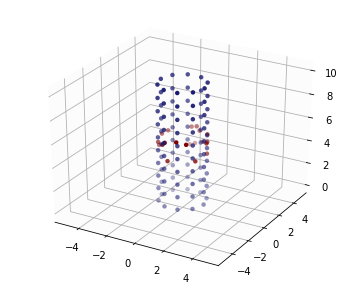

In [11]:
matplotlib.rcParams['figure.figsize'] = (6, 5)    # adjustment for display in jupyter notebook only
axsyn3d = pyplot.subplot(projection='3d')
synapse_network_diagram_3d(axsyn3d, network)
pyplot.show()

---

### Distances Between Neurons

#### Calculating distances

Distances between neurons are automatically calculated every time neurons are positioned (by a call to `<NetworkGeometry>.position_neurons(...)`)

Distances can also be manually calculated at any time with a call to `<NetworkGeometry>.calculate_distances()`

Each geometry calculates distances in a manner appropriate to the geometry. A description of each distance calculation is given below:

Geometry class | Distance calculation
---|---
PlaneSurface|Euclidean distance in 2D plane
CylinderSurface|Euclidean distance in 2D unwrapped surface plane, torroidal wrapping in circumferal axis
TorusSurface|Euclidean distance in 2D unwrapped surface plane, torroidal wrapping in both circumferal axes
SpheroidSurface|Geodesic ('great circle') distance over the spheroid surface
CubeVolume | Euclidean distance in 3D space
CylinderVolume | Euclidean distance in 3D space
TorusVolume | Euclidean distance in 3D unwrapped circular prism, torroidal wrapping
AnnulusVolume | Euclidean distance in 3D unwrapped rectangular prism, torroidal wrapping
EllipsoidVolume | Euclidean distance in 3D space


#### Accessing calculated distances
The matrix of calculated pairwise distances between positioned neurons is accessible as the `<NetworkGeometry>.distances` (or `<NeuronNetwork>.<NetworkGeometry>.distances>`) attribute.

---
<div class="alert alert-block alert-info">Distances between neurons in our network were already calculated when the neurons were positioned:</div>

In [12]:
network.geometry.distances

array([[ 0.        ,  0.9424778 ,  1.88495559, ...,  4.85974507,
         6.16793806,  6.17814863],
       [ 0.9424778 ,  0.        ,  0.9424778 , ...,  4.4083222 ,
         5.83785607,  6.53761977],
       [ 1.88495559,  0.9424778 ,  0.        , ...,  4.12625931,
         5.64749465,  7.00627953],
       ..., 
       [ 4.85974507,  4.4083222 ,  4.12625931, ...,  0.        ,
         1.56294903,  4.9863329 ],
       [ 6.16793806,  5.83785607,  5.64749465, ...,  1.56294903,
         0.        ,  4.53456499],
       [ 6.17814863,  6.53761977,  7.00627953, ...,  4.9863329 ,
         4.53456499,  0.        ]])

---
## Network Connectivity

### Setting network connectivity

Each network stores separate connectivity weighth matrices for excitatory synaptic connections, inhibitory synaptic connections, and gap junction connections, namely:

- `<NeuronNetwork>.connectionWeights_synExcit`
- `<NeuronNetwork>.connectionWeights_synInhib`
- `<NeuronNetwork>.connectionWeights_gap`

**These matrices can be set/modified directly, as in:**
```python
network = LIFNetwork()
#...
network.connectionWeights_synExcit = numpy.random.rand(network.N, network.N)
```

**Or connectivity matrices can be set using a call to one of the network's connectivity setter functions:**
- `<NeuronNetwork>.set_synaptic_connectivity(connectivity, updateNeurons=None, synapseType=<'excitatory'|'inhibitory'>)`
- `<NeuronNetwork>.set_gapjunction_connectivity(connectivity, updateNeurons=None)`

These functions provide checks on connectivity matrix dimensionality and format. They also allow for setting the connectivity vectors for a subset of neurons. For example, the following code sets the connectivity of 5 specific neurons to random weights, while leaving the rest of the weights alone:
```python
network = LIFNetwork()
#...
network.set_gapjunction_connectivity(connectivity=numpy.random.rand(5, network.N), updateNeurons=[2,17,34,87,96])
```

### Generating network connectivity matrices/vectors

Functions for generating connectivity matrices or vectors according to a number of heuristics are provided in the `neuronalnetworks.connectivities.connectivity_generation` module:

- `generate_connectivity_vector(N, adjacencyScheme, initWeightScheme, args={}, sparsity=0.0, selfLoops=False, neuronID=None)`   
 - Generates a 1xN vector of connectivity weights according to the given adjacencyScheme, initWeightScheme, and other arguments:
   - `N`: number of neurons [in network] for which a connectivity weight should be generated.
   - `adjacencyScheme`: explained below
   - `initWeightScheme`: explained below
   - `args`: dictionary of arguments relevant to the given `adjacencyScheme` and `initWeightScheme`, explained below
   - `sparsity`: multiplier applied to generated weights vector to increase sparsity if argument is non-zero
   - `selfLoops`: If False, ensure vector has 0 weight at index corresponding to this same neuron.
   - `neuronID`: The neuron ID for which connectivity vector is being generated, necessary to know which vector element represents a self-connection
 
 
- `generate_connectivity_vectors(neuronIDs, N, adjacencyScheme, initWeightScheme, args={}, sparsity=0.0, selfLoops=False)`
 - Generates a set of 1xN vectors of connectivity weights according to the given adjacencyScheme, initWeightScheme, and other arguments by repeated calls to `generate_connectivity_vector`:
   - `neuronIDs`: List of neuronIDs for which a connectivity weight vector should be generated.
   - `N`: number of neurons [in network] for which a connectivity weight should be generated.
   - `adjacencyScheme`: explained below
   - `initWeightScheme`: explained below
   - `args`: dictionary of arguments relevant to the given `adjacencyScheme` and `initWeightScheme`, explained below
   - `sparsity`: multiplier applied to generated weights vector to increase sparsity if argument is non-zero
   - `selfLoops`: If False, ensure vector has 0 weight at index corresponding to this same neuron.
   
   
- `generate_connectivity_matrix(N, adjacencyScheme, initWeightScheme, args={}, sparsity=0.0, selfLoops=False)`
 - Generates a NxN connectivity weight matrix according to the given adjacencyScheme, initWeightScheme, and other arguments by repeated calls to `generate_connectivity_vector`:
   - `N`: number of neurons [in network] for which a connectivity weight should be generated.
   - `adjacencyScheme`: explained below
   - `initWeightScheme`: explained below
   - `args`: dictionary of arguments relevant to the given `adjacencyScheme` and `initWeightScheme`, explained below
   - `sparsity`: multiplier applied to generated weights vector to increase sparsity if argument is non-zero
   - `selfLoops`: If False, ensure vector has 0 weight at index corresponding to this same neuron.
   
#### Adjacency Schemes
Several heuristics for determining which neurons shall be adjacent (i.e., have non-zero connectivity weight) are implemented. To use an adjacency scheme, pass the corresponding scheme string name (see table below) as the `adjacencyScheme` argument to one of the above generator functions, and pass a dictionary that includes the appropriate scheme arguments as the `args` argument (see table below).

adjacencyScheme | Description | Scheme arguments
---|---|---
`'nonspatial_probability'` | Adjacency between $i,j$ with fixed probability $p$ | `{'prob':<float>}`
`'nonspatial_degree'` | Each neuron has $degree$ outgoing connections to randomly chosen targets | `{'degree':<int>}`
`'nearest_neighbors'` | Each neuron has $k$ outgoing connections to its $k$ nearest neighbors | `{'k':<int>, 'distances':<2D distances matrix>}`
`'distance_threshold'` | Each neuron has outgoing connections to all neurons within distance $d_{thresh}$ | `{'d_thresh':<int>, 'distances':<2D distances matrix>}`
`'distance_probability'` | Adjacency between $i,j$ with probability as function of distance between $i$ and $j$ | (see below)
|probability decreases linearly with distance $\\p^{ij} = m D(i,j) + b$:|`{'adj_prob_dist_fn':'linear', 'm_a':<float>, 'b_a':<float> 'distances':<2D distances matrix>}`
|probability decays exponentially with distance $\\p^{ij} = p_0 e^{\sigma D(i,j)}$:|`{'adj_prob_dist_fn':'exponential', 'p0_a':<float>, 'sigma_a':<float> 'distances':<2D distances matrix>}`


#### Initial Weight Schemes
Several heuristics for initializing the connection weights of pre-determined adjacent neurons are implemented. To use an initial weight scheme, pass the corresponding scheme string name (see table below) as the `initWeightScheme` argument to one of the above generator functions, and pass a dictionary that includes the appropriate scheme arguments as the `args` argument (see table below).

initWeightScheme | Description | Scheme arguments
---|---|---
`'constant'` | Weights of all adjacencies are equal, $c_w$ | `{'c_w':<float>}`
`'uniform'` | Weights of adjacencies are randomly sampled from uniform distribution over [low, high] | `{'low':<float>, 'high':<float>}`
`'normal'` | Weights of adjacencies are randomly sampled from normal distribution $N(mean,std)$ | `{'mean':<float>, 'std':<float>}`
`'distance'` | Weight of adjacency $i,j$ is a function of distance between $i$ and $j$ | (see below)
|weight decreases linearly with distance $\\w^{ij} = m D(i,j) + b$:|`{'init_weight_dist_function':'linear', 'm_w':<float>, 'b_w':<float> 'distances':<2D distances matrix>}`
|weight decays exponentially with distance $\\w^{ij} = p_0 e^{\sigma D(i,j)}$:|`{'init_weight_dist_function':'exponential', 'p0_w':<float>, 'sigma_w':<float> 'distances':<2D distances matrix>}`

**Note:** It should be reiterated that the user is not limited to these connectivity generation functions. Ultimately, the network object's connectivity matrices simply store standard numpy 2d arrays, and any method for generating arbitrary matrices/vectors in the form of numpy arrays can be used to set and modify connectivities as desired.


---
<div class="alert alert-block alert-info">**Let's configure our synaptic connectivities such that probability of neuron adjacency decays with their distance. Excitatory synaptic connections will have weights that decrease linearly in distance, while inhibitory synaptic connections will have weights that decrease exponentially in distance:**</div>

In [13]:
W_synE = generate_connectivity_vectors(neuronIDs=neuronIDs_excit, N=network.N, adjacencyScheme='distance_probability', initWeightScheme='uniform', 
                                       args={'adj_prob_dist_fn':'exponential', 'p0_a':1.0, 'sigma_a':0.9,
                                             'low':20.0, 'high':40.0,
                                             'distances':network.geometry.distances[neuronIDs_excit]} )

W_synI = generate_connectivity_vectors(neuronIDs=neuronIDs_inhib, N=network.N, adjacencyScheme='distance_probability', initWeightScheme='distance',
                                       args={'adj_prob_dist_fn':'exponential', 'p0_a':1.0, 'sigma_a':0.6,
                                             'init_weight_dist_fn':'exponential', 'p0_w':40.0, 'sigma_w':2.0,
                                             'distances':network.geometry.distances[neuronIDs_inhib]} )

network.set_synaptic_connectivity(connectivity=W_synE, synapseType='e', updateNeurons=neuronIDs_excit)
network.set_synaptic_connectivity(connectivity=W_synI, synapseType='i', updateNeurons=neuronIDs_inhib)

Let's take a look at our network's synaptic connectivity:

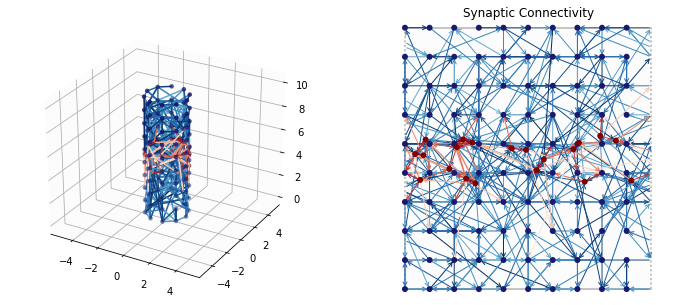

In [14]:
matplotlib.rcParams['figure.figsize'] = (12, 5)    # adjustment for display in jupyter notebook only
axsyn3d = pyplot.subplot(1, 2, 1, projection='3d')
synapse_network_diagram_3d(axsyn3d, network)
axsyn2d = pyplot.subplot(1, 2, 2)
synapse_network_diagram_2d(axsyn2d, network)
pyplot.show()

<div class="alert alert-block alert-info">**We can also configure our network's gap junction connectivity. For gap junctions, let's use a nearest-neighbors adjacency scheme and a constant connection weight. But let's add an additional element  to this connectivity: Let's make the gap junction connectivity increasingly sparse as you move up the length of the cylinder:**</div>

In [15]:
W_synG = numpy.zeros(shape=(network.N, network.N))    # starting with empty container for connectivity matrix

for nID in network.get_neuron_ids():
    # Generate and set connectivity vectors one neuron at a time, 
    # using their percentile height on the cylinder as a parameter 
    # for the additional sparsity applied to the generated vector.
    heightPercentile = network.geometry.cartesianCoords[nID][2]/network.geometry.h
    W_synG[nID] = generate_connectivity_vector(N=network.N, neuronID=nID,
                                               adjacencyScheme='nearest_neighbors', initWeightScheme='constant', 
                                               args={'k':4,'c_w':1.0, 'distances':network.geometry.distances[int(nID)]}, 
                                               sparsity=heightPercentile )

network.set_gapjunction_connectivity(connectivity=W_synG)

Now let's take a look at our network's gap junction connectivity:

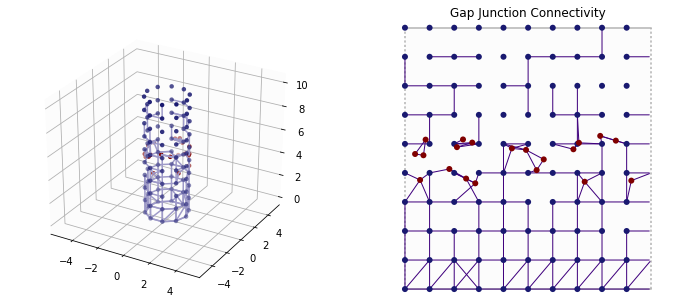

In [16]:
matplotlib.rcParams['figure.figsize'] = (12, 5)    # adjustment for display in jupyter notebook only
axgap3d = pyplot.subplot(1, 2, 1, projection='3d')
gapjunction_network_diagram_3d(axgap3d, network)
axgap2d = pyplot.subplot(1, 2, 2)
gapjunction_network_diagram_2d(axgap2d, network)
pyplot.show()

---
## Neuron Labels

It is often useful to be able to reference a group of neurons directly. For example, we one may want to modify parameters of only the neurons receiving inputs, or specifically track the firing times of neurons with more than 2 gap junction connections, or calculate the firing rate of designated 'output' neurons.

Along these lines, neurons can be given string labels. Labels can be simply act as descriptive notes, or labels can be used to reference the corresponding group of neurons for specific modification, visualization, etc.

### Setting neuron labels

Neuron labels can be set to a desired string either:
- To a batch of newly added neurons by passing the string to the `label` argument of the `<NeuronalNetwork>.add_neurons()` function. This assigns the label to all neurons added in this batch.
    
    For example: `network.add_neurons(<...other neuron params...>, label='input'>)`
    
     
- By directly modifying the `neuronLabels` list attribute of a `NeuronalNetwork` object.

    For example: `network.neuronLabels[[0,1,2,3]] = 'output'`

### Referencing neurons by label

#### Getting neuronIDs of neurons with a given label

A list of the neuronIDs for all neurons whose label includes a given string can be retrieved using the network object's `get_neuron_ids(labels=<list of strings>)` function. This function returns the list of neuronIDs for all neurons whose label includes any of the strings in the list passed to the `labels` argument.

For example:
```python
neuronIDs_io = network.get_neuron_ids(labels=['input', 'output']
```

#### Accessing neuron attributes/parameters/variables/etc by neuronID/label

Neurons can be referenced by neuronID(s) to reference or modify attributes/parameters/variables/etc. This can be done for any set of neuronIDs obtained by any means, but when paired with retrieving neuronIDs by label this enables reference and modification of neurons specifically by label.

For example, to get the voltages of all IO neurons that are designated either 'input' or 'output':
```python
neuronIDs_io = network.get_neuron_ids(labels=['input', 'output']
voltages_io = network.V[neuronIDs_io]                                      
```

---
<div class="alert alert-block alert-info">**Let's designate the 10 neurons highest-poisitioned on the cylinder as 'output' neurons by labeling them as such.** <br> We will specifically reference this set of output neurons later on in the simulation.</div>

In [17]:
neuronIDs_geoTop10 = numpy.argpartition(network.geometry.cartesianCoords[:,2], -10)[-10:]
neuronIDs_outputs  = neuronIDs_geoTop10
network.neuronLabels[neuronIDs_outputs] = 'output'

In [18]:
neuronIDs_outputs

array([91, 90, 93, 96, 94, 95, 97, 98, 99, 92])

---
## Network Inputs

External inputs can be applied to the network by mapping input values to neurons in the network. Network connectivity enables one or more distinct inputs each to be mapped to one or more neurons, and single neurons can receive any number of inputs.

#### Injected Currents as Neuron Inputs
All of the currently implemented neuronal dynamics models (LIF, FHN, Izhikevich) support external inputs in the form of injected currents. Namely, the $I_{inp}$ term in the dynamics of each model (see above) represents an external input current component of the dynamics. In these models, this input current $I_{inp}^{i}$ is defined as:
$$
I_{inp} = \mathbf{W}_{inp} a
$$
where $a$ is a vector of input values and $\mathbf{W}_{inp}$ is the weight matrix mapping these input values to the $N$ neurons in the network.

### Adding Inputs to the Network

Inputs are added to a network by calling the network object's `add_inputs()` function, and passing the number of inputs to add to the network as an argument to the function. This function call allocates the appropriate number of elements in the network's vector of input values.

---
<div class="alert alert-block alert-info">**Let's allocate 2 inputs to our network:**</div>

In [19]:
numInputs = 2
network.add_inputs(numInputsToAdd=numInputs)

---
### Setting Input Mapping

Each network stores a $[numInputs \times N]$ connectivity weight matrix mapping input values to neurons, namely:
`<NeuronNetwork>.connectionWeights_inputs`

**This matrix can be set/modified directly, as in:**
```python
network = LIFNetwork()
#...
network.connectionWeights_inputs = numpy.random.rand(network.numInputs, network.N)
```

**Or the matrix can be set using a call to the network's input connectivity setter function:**
`<NeuronNetwork>.set_input_connectivity(connectivity)`

 - This function provides checks on connectivity matrix dimensionality and format.
 
#### Generating Input Mapping Matrices
The user can use any arbitrary desired method to generate matrices for mapping inputs to neurons. The functionalities of the `connectivity_generation()` function described above for network neuronal connectivity generation can also be used to generated input connectivity matrices where applicable and desired.

---
<div class="alert alert-block alert-info">**Let's select 10 excitatory neurons randomly from the bottom half of our network to be input neurons.** <br> We have allocated 2 inputs for our network. We will map input 1 to the first of our 10 randomly selected input neurons, and map input 2 to the remaining 9 selected input neurons.</div>

In [20]:
# Randomly select 10 excitatory neurons from the bottom half of the geometry:
neuronIDs_geoBotHalf = numpy.argpartition(network.geometry.cartesianCoords[:,2], int(network.N/2))[:int(network.N/2)]
neuronIDs_inputs = numpy.random.choice( numpy.intersect1d(neuronIDs_geoBotHalf, neuronIDs_excit), 10, replace=False )
network.neuronLabels[neuronIDs_inputs] = 'input'    # label the selected input neurons with 'input'

# Generate a matrix that maps input 1 to the first selected input neuron, 
# and maps input 2 to the remaining input neurons:
W_inp = numpy.zeros(shape=(numInputs, network.N))
W_inp[0, numpy.sort(neuronIDs_inputs)[0]] 	= 1.0
W_inp[1, numpy.sort(neuronIDs_inputs)[1:]]	= 1.0

# Set the input connectivity to the matrix we generated:
network.set_input_connectivity(connectivity=W_inp)

In [21]:
neuronIDs_inputs

array([21, 38, 45,  3,  1, 44, 39, 14, 31, 33])

---
### Setting Input Values

**Input values can be set with a call using a call to the network's input setter function:**

`<NeuronNetwork>.set_input_vals(vals=<list|array>, inputIDs=<list|array, optional>)`

This function updates the entire `inputVals` vector, or a subset of its elements as specified by `inputIDs`, to the given list of values.

**Or input values can be set/modified directly, for example:**
```python
network = LIFNetwork()
#...
network.inputVals[0] = numpy.random.normal(0.0, 1.0)    # setting the 0th input to a random gaussian value
```

**Note:** Input values maintain their set values forever or until set to a new value. For time varying input values, update the value of the input with a new set each time step (or as often as desired) in the simulation loop (more details about simulation loop below).

---
<div class="alert alert-block alert-info">We will update our input values continuously throughout the simulation loop later on.</div>

---
### Generating Input Values

The user can use any arbitrary desired method to generate input values/vectors. Simply generate the input values as desired and set the network's input values as described above.

#### Built-In Input Value Generators

A number of input classes have been implemented for conveniently generating input values according to common time-varying functions (e.g., constant, pulse, linear, sinusoidal). 

To use these built-in input value generators, simply instantiate an instance of the input generator and then call the input object's `val(t)` function, passing the time $t$, when desired to generate the corresponding value. For example:
```python
network = LIFNetwork()
pulseInput = PulseInput(pulseVal=100.0, pulsePeriod=50.0, pulseDuration=10.0, baseVal=0.0)
#...
#{in simulation loop}:
    network.inputVals[0] = pulseInput.val(network.t)
```

The currently implemented built-in input generator classes are described in the table below:

Input Class | Value Generation Function | Constructor
---|---|---
ConstantInput |`val = constVal` $\forall t$|`ConstantInput(constVal=c)`
LinearInput | `val = initVal + slope*t` | `LinearInput(initVal, slope)`
SinusoidalInput | `val = amplitude * sin((2pi/period)*t)` | `SinusoidalInput(amplitude, period)`
PulseInput |`val = pulseVal if` $t \in $`[t%pulsePeriod, pulseStart+pulseWidth]` `else baseVal`|`PulseInput(pulseVal, pulsePeroid, pulseWidth, baseVal`

---
<div class="alert alert-block alert-info">**Let's have input 1 be a constant input current. We instantiate the corresponding input value generating object:** <br> We will use this object to generate values when setting input values each time step in the simulation loop later on. </div>

In [22]:
constantInput 	= ConstantInput(constVal=250.0)

<div class="alert alert-block alert-info">Let's take a moment to visualize the final constructed network, including positions of labeled input and output neurons:</div>

Input neurons are visualized as green triangles. Output neurons are visualized as orange squares.

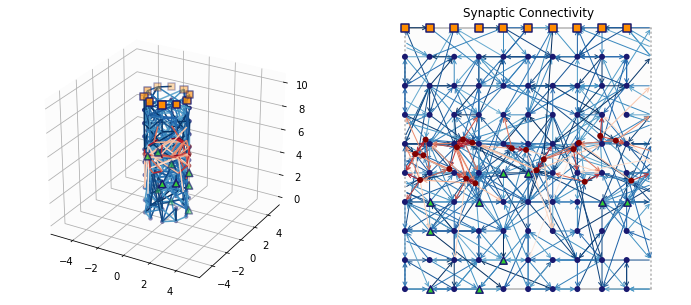

In [23]:
matplotlib.rcParams['figure.figsize'] = (12, 5)    # adjustment for display in jupyter notebook only
axsyn3d = pyplot.subplot(1, 2, 1, projection='3d')
synapse_network_diagram_3d(axsyn3d, network)
axsyn2d = pyplot.subplot(1, 2, 2)
synapse_network_diagram_2d(axsyn2d, network)
pyplot.show()

<div class="alert alert-block alert-info">Let's also identify the neuronIDs of the neurons that are neither input nor output neurons ("non-IO neurons"):</div>

In [24]:
neuronIDs_nonIO = [nID for nID in network.get_neuron_ids() if nID not in neuronIDs_inputs and nID not in neuronIDs_outputs]

---

**---**

# Simulating a neuronal network

A simulation of a neuronal network consists of iteratively upating the network's states through forward integration of the network's neuronal dynamics, while optionally simultaneously applying inputs to the network, accessing and modifying network variables and parameters according to the network's states or other factors, and other possible interventions depending on the desired simulation scenario.

Integration of neuronal dynamics for network updates is implemented for each model and very easily executed. And since all network variables and parameters are accessible at all times, the user has complete control over the network during the simulation and there are no limites on the possible simulation scenarios that can be run.

## Overview of a simulation

Simulations follow the following basic pattern:
1. Construct a network (i.e., add neurons, set connectivities, add inputs, etc)
2. Initialize the simuation
    - Specify the length of the simulation and the length of each time step
    - Allocate data structures for logging network variables/parameters of interest during the simulation
3. Simulation loop (`while t < T_max`):
    - Access/modify network or other simulation variables/parameters as desired
    - Update network (i.e. neurons) states according to network model dynamics and current states/parameters
    - Access/modify network or other simulation variables/parameters as desired
    - Repeat
4. Process Simulation Data
    - Calculate on logged network/simulation data as desired
    - Store network/simulation data as desired
    - Generate plots of network/simuation data as desired
    
This package provides functionality for automating many of these simulation tasks. However, the user is free to handle these tasks by directly interfacing network attributes/parameters/variables if desired.

## Initializing a simulation

Simulation time factors, such as simulation length and time step size, must be specified, related time-related attributes must be calculated (e.g., number of timesteps), and data structures for storing network states in each time step must be allocated (if logging is enabled).

The network object's `<NeuronalNetwork>.initialize_simulation(T_max, deltaT)` function handles all these initialization tasks based on the specified values of `T_max` (i.e. length of simulation in time unitis, in ms for currently implemented models) and `deltaT` (i.e. the length of a time step, in ms for currently implemented models). (Default `T_max` and `deltaT` values are specified for each dynamics model if no values are passed as arguments.)

For example:
```python
network = LIFNetwork()
#...
network.initialize_simulation(T_max=1000, deltaT=0.5)
```
This function sets all time related properties and allocates the appropriate data structures for logging time-varying network variables for each time step.

## The simulation loop

The simulation loop advances the state of the network through forward integration of its model's dynamics one time step at a time until the maximum simulation time has been reached. 

### The most basic simulation loop
The simplest simulation loop using the package's provided functions is shown here, and the details of the functions used are given below:
```python
while(network.sim_state_valid()):
    network.sim_step()
```

#### The `sim_state_valid()` function

This function first checks that the simulation has been initialized properly - that is, that all necessary simulation time properties have been set and necessary data structures have been allocated. If the simulation has not been initialized, it makes a call to `initialize_simulation()` to attempt to do so.

Given successful initialization, this function returns `True` if the current time `t` is within the specified simulation time `T_max`, and returns `False` if the maximum simulation time has been reached.

#### The `sim_step()` function

This function advances the simulation one time step by:
1. Forward integration of network dynamics for one time step with call to `<NeuronalNetwork>.network_update()`
    - The `network_update` function is where the integration of network dynamics is implemented. Every neuronal model subclass has a unique implementation of this function according to its dynamics.
2. Logging current network variables with call to `<NeuronalNetwork>.log_current_variable_values()`

The details of the `sim_step()` implementation can usually be ignored; simply call this function to advance the network state for one time step.

### More sophisticated simulation loops

More sophisticated simulation loops can be implemented by introducing other actions before and/or after the call to `sim_step()`. 

For example, network input values can be updated before calling `sim_step()`, the network's parameters, geometry, or connectivities can be updated according to the current states of the network before/after `sim_step()`, other variables or objects separate from the network can be introduced and referenced to modify the network according to some relationship, or multiple networks can even be made to influence each others inputs/parameters/etc based on their respective states.

Some of these more sophisticated simulation aspects are illustrated in the simulation scenario implmented in the tutorial.

## Simulation data

For each neuronal model, the values of all time-varying network variables for each neuron at each time step can be stored in a vector (when logging for the given variable is enabled, all enabled by default). Constant parameters are not logged at each time step. (See description of models above for more information on which terms are time-varying and constant for each model.)

### Network variable time series lists

Each network object has a dictionary attribute that contains vectors storing the values of all time-varying network variables for each neuron at each time step. This dictionary has the following key-value structure:
`<NeuronalNetwork>.neuronLogs = { 'variableName1': {'data':[[list of time-step values for neuron 0],[<vector of time-step values for neuron 1],...], 'enabled':<True|False>}, 
                                  'variableName2': {'data':[[list of time-step values for neuron 0],[<vector of time-step values for neuron 1],...], 'enabled':<True|False>},
                                  ... }`
(See the description of models above for variable names used in code for each model variable.) 

*(The data structure for logs at each `neuronLogs['variableName']['data']` key may be converted to matrices instead of lists of lists in the future)*

If the `enabled` key of a variable's dictionary holds the value `False`, then values for that model variable will not be logged at time steps during the simulation.

For example, the time series of voltage values for the neuron with `neuronID=10` in a LIF network can be accessed by:
```python
network = LIFNetwork()
#...
voltageTimeSeries = network.neuronLogs['V']['data'][10]
```

### Network variable pandas DataFrame

A pandas DataFrame storing the values of all time-varying network variables for each neuron at each time step can be generated by calling the network object's `<NeuronalNetwork>.get_neurons_dataframe()` function. This DataFrame can then be used for data analysis, saving the simulation data to file, creating plots, and other uses of pandas DataFrames.

For example:
```python
network = LIFNetwork()
#...
#{...simulation loop...}
simulationDataFrame = network.get_neurons_dataframe()
simulationDataFrame.to_csv('my_LIF_simulation_data.csv')
```



---



---

<div class="alert alert-block alert-info">
**Now that we have constructed a network -- complete with multiple sets of neurons positioned on a geometric surface, synaptic and gap junction connectivities, and multiple inputs -- we will explore the behavior of this network in a rich scenario.**
<br>
The following simulation scenario illustrates some ways of interacting with neuronal networks to create a sophisticated simulation.
</div>


<div class="alert alert-block alert-info">
<font size="4">**Our Simulation Scenario:**</font size>
<br>
**The radius of the network's cylinder surface geometry will grow spontaneously at a constant rate.** <br>
- As the geometry changes with this increasing radius, neuron positions and calculated distances will update accordingly. <br>
- The outgoing connection weights of inhibitory neurons will continuously update, and thus inhibitory connections, whose weights decrease exponentially with distance, will decrease as the radius increases and neuron distances grow.  <br>
- The connection weights of excitatory neurons will be held static at their intial weights. <br>
- The network's second input will be a current proportional to the difference between the cylinder's current radius and its baseline radius. Thus, this input current will increase linearly along with the radius. <br>
**When the average firing rate of the designated 'output' neurons reaches 30 Hz or greater, this triggers the cylinder surface's radius to snap back to its baseline radius.** <br>
- Output neuron spikes will be tracked in order to calculate a moving average of firing rate 
</div>


---
<div class="alert alert-block alert-info">
**We begin by initializing a simulation with duration $T_{max}$ of 2000ms and time step $\Delta t$ of 0.5ms:**
</div>


In [25]:
network.initialize_simulation(T_max=2000, deltaT=0.5)

<div class="alert alert-block alert-info">
**Declare variables for handling aspects of the simulation scenario that are beyond the network/neuronal attributes:**
</div>


<div class="alert alert-block alert-info">
Declare variables for updating the radius of the cylinder surface according to the simulation scenario:
</div>


In [26]:
# The current cylinder surface radius:
# network.geometry.r

# The baseline radius to which the geometry is reset when output firing rate is sufficiently high:
radius_baseline = network.geometry.r    # initialized to the geometry's initial defined radius

# The constant rate at which the radius grows:
dRdt = 0.005    # 0.005 units/ms = 5 units/sec

<div class="alert alert-block alert-info">
Variables for calculating the average firing rate of output (and also input) neurons:
</div>


In [27]:
# Length of the window (ms) for calculating moving average of firing rate:
T_rateSampleWindow = 25    

# Store the number of spikes at each time step within the current window (lists to act as FIFO queues):
outputSpikeCounts = [0 for n in range(int(T_rateSampleWindow/network.deltaT))]
inputSpikeCounts = [0 for n in range(int(T_rateSampleWindow/network.deltaT))]
nonIOSpikeCounts = [0 for n in range(int(T_rateSampleWindow/network.deltaT))]

# The current average spike rates:
inputSpikeRate = 0
outputSpikeRate = 0
nonIOSpikeRate = 0

<div class="alert alert-block alert-info">
Variables for recording the values of interest for the scenario:
</div>


In [28]:
# Lists for storing the values of the radius and firing rates at each time step:
log_radius = numpy.zeros(network.numTimeSteps+1)
log_outputRates = numpy.zeros(network.numTimeSteps+1)
log_inputRates = numpy.zeros(network.numTimeSteps+1)
log_nonIORates = numpy.zeros(network.numTimeSteps+1)

# Record the initial values of the radius and firing rates before the simulation loop starts:
log_radius[network.timeStepIndex] = network.geometry.r
log_inputRates[network.timeStepIndex] = inputSpikeRate    # = 0 initially
log_outputRates[network.timeStepIndex] = outputSpikeRate  # = 0 initially
log_nonIORates[network.timeStepIndex] = nonIOSpikeRate    # = 0 initially

<div class="alert alert-block alert-info">
**We now implement the simulation loop:**
</div>


In [29]:
# while within the allotted simulation time:
while(network.sim_state_valid()):
    # Update the radius of the cylinder surface, which is increasing at a constant rate:
    # (This will automatically trigger updates to neuron positions and calcualted distances)
    # ( ^ this is the time limiting step of this sim loop)
    network.geometry.set_r(network.geometry.r+dRdt)
    
    # Update the inhibitory neuron connectivity based on the new geometry and neuron positions/distances:
    W_synI = generate_connectivity_vectors(neuronIDs=neuronIDs_inhib, N=network.N, adjacencyScheme='given', initWeightScheme='distance',
                                       args={'given_adj':network.connectionWeights_synInhib[neuronIDs_inhib],
                                             'init_weight_dist_fn':'exponential', 'p0_w':40.0, 'sigma_w':2.0,
                                             'distances': network.geometry.distances[neuronIDs_inhib] } )
    network.set_synaptic_connectivity(connectivity=W_synI, synapseType='i', updateNeurons=neuronIDs_inhib)

    # Set the input vals:
    # - Input 1 is a constant current
    # - Input 2 is a current that increases in magnitude in proportion to the radius's enlargement over baseline:
    network.set_input_vals( vals=[constantInput.val(network.t), 100*(network.geometry.r - radius_baseline)] )

    # Advance the state of the network's neurons by integrating their dynamics:
    network.sim_step()

    # Calculate the current average output neuron spike rate within the moving average window:
    outputSpikeCounts.pop(0)
    outputSpikeCounts.append(numpy.sum(network.spikeEvents[neuronIDs_outputs]))
    outputSpikeRate = (sum(outputSpikeCounts)/len(neuronIDs_outputs))*(1000/(T_rateSampleWindow))

    # (Also calculate the current average input neuron spike rate within the moving average window:)
    inputSpikeCounts.pop(0)
    inputSpikeCounts.append(numpy.sum(network.spikeEvents[neuronIDs_inputs]))
    inputSpikeRate = (sum(inputSpikeCounts)/len(neuronIDs_inputs))*(1000/(T_rateSampleWindow))
    
    # (Also calculate the current average non-input/output neuron spike rate within the moving average window:)
    nonIOSpikeCounts.pop(0)
    nonIOSpikeCounts.append(numpy.sum(network.spikeEvents[neuronIDs_nonIO]))
    nonIOSpikeRate = (sum(nonIOSpikeCounts)/len(neuronIDs_nonIO))*(1000/(T_rateSampleWindow))

    # If the average output neuron spike rate is sufficiently high, reset the cylinder radius:
    if(outputSpikeRate >= 30.0):
        network.geometry.r = radius_baseline

    # Record the current values of the radius and firing rates:
    log_radius[network.timeStepIndex] = network.geometry.r
    log_outputRates[network.timeStepIndex] = outputSpikeRate
    log_inputRates[network.timeStepIndex] = inputSpikeRate
    log_nonIORates[network.timeStepIndex] = nonIOSpikeRate

<div class="alert alert-block alert-info">
**Our simulation is complete! Let's visualize the results:**
</div>

Plotting the cylinder radius and firing rates of input, output, and non-IO neurons:

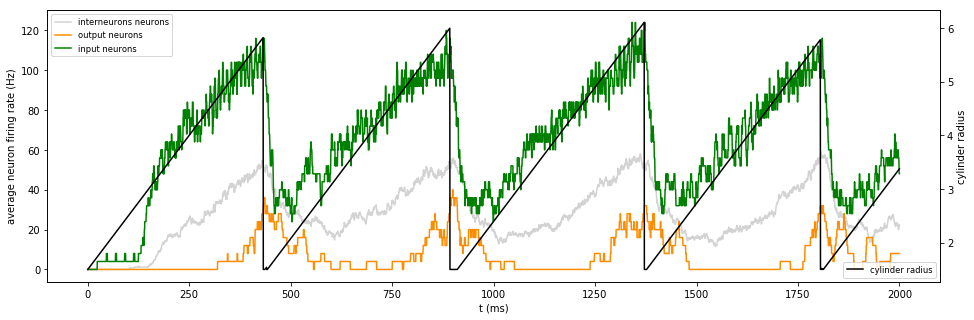

In [30]:
matplotlib.rcParams['figure.figsize'] = (16, 5)    # adjustment for display in jupyter notebook only
ax_radiusrates = pyplot.subplot()
rAx1 = ax_radiusrates
rAx2 = rAx1.twinx()
rAx2.plot(log_radius, color='black')
rAx1.plot(log_nonIORates, color='lightgray')
rAx1.plot(log_outputRates, color='darkorange')
rAx1.plot(log_inputRates, color='green')
rAx1.set_ylabel('average neuron firing rate (Hz)')
rAx2.set_ylabel('cylinder radius')
rAx1.legend(['interneurons', 'output neurons', 'input neurons'], loc='upper left', fontsize='small')
rAx2.legend(['cylinder radius'], loc='lower right', fontsize='small')
rAx1.set_xlabel('t (ms)')
#rAx1.tick_params(axis='x', which='major')
rAx1.set_xticklabels([0, int(network.T_max/8)*0, int(network.T_max/8)*1, int(network.T_max/8)*2, int(network.T_max/8)*3, int(network.T_max/8)*4, int(network.T_max/8)*5, int(network.T_max/8)*6, int(network.T_max/8)*7, int(network.T_max/8)*8])
#rAx1.set_xticklabels([0, 0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000])
# rAx1.set_xticks([0, 1000, 2000])
pyplot.show()

Raster plot of spike times for all neurons: <br> (green: input neurons, orange: output neurons, blue: non-IO excitatory neurons, red: non-IO inhibitory neurons)

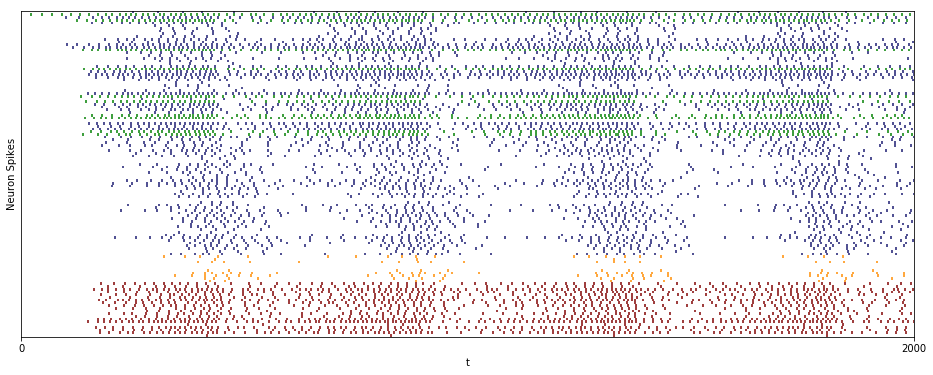

In [ ]:
matplotlib.rcParams['figure.figsize'] = (16, 6)    # adjustment for display in jupyter notebook only
axraster = pyplot.subplot()
spike_raster_plot(axraster, network, colorSynapseTypes=True, colorIOTypes=True)
pyplot.show()

Average spike rate of each neuron in the network: <br>
(Depicted in heatmap style on network diagram; white: no firing, dark red: high firing rate)

In [ ]:
matplotlib.rcParams['figure.figsize'] = (16, 5)    # adjustment for display in jupyter notebook only
axheatrate = pyplot.subplot(1, 2, 1, projection='3d')
rate_network_diagram_3d(axheatrate, network)
axheatrate = pyplot.subplot(1, 2, 2)
rate_network_diagram_2d(axheatrate, network, truePlaneDimensions=False)
pyplot.show()

Voltage/Current traces for the input neurons:

In [ ]:
matplotlib.rcParams['figure.figsize'] = (16, 16)    # adjustment for display in jupyter notebook only

neuronsDataFrame 	= network.get_neurons_dataframe()

gs2 = gridspec.GridSpec(len(neuronIDs_inputs), 1)
gs2.update(left=0.0, right=1.0, top=1.0, bottom=0.00, hspace=0.0)

y1_axlim = [neuronsDataFrame.loc[(neuronsDataFrame['neuron_id'].isin(neuronIDs_inputs)), ['V']].min().min(),
            neuronsDataFrame.loc[(neuronsDataFrame['neuron_id'].isin(neuronIDs_inputs)), ['V']].max().max()]
y2_axlim = [neuronsDataFrame.loc[(neuronsDataFrame['neuron_id'].isin(neuronIDs_inputs)), ['I_excit', 'I_inhib', 'I_gap', 'I_input']].min().min(),
                neuronsDataFrame.loc[(neuronsDataFrame['neuron_id'].isin(neuronIDs_inputs)), ['I_excit', 'I_inhib', 'I_gap', 'I_input']].max().max()*1.05] #*1.05 is to give a 5% margin at high end to make sure highest currents' lines are visible

for i, nID in enumerate(numpy.sort(neuronIDs_inputs)):
    ax_n = pyplot.subplot(gs2[i, :])
    
    x_series 	= neuronsDataFrame.loc[(neuronsDataFrame['neuron_id']==nID), 't'].values
    trace_V 	= {'data':neuronsDataFrame.loc[(neuronsDataFrame['neuron_id']==nID), 'V'].values, 'label':'V', 'color':'black', 'alpha':1.0, 'linestyle':'-'}
    trace_Iex 	= {'data':neuronsDataFrame.loc[(neuronsDataFrame['neuron_id']==nID), 'I_excit'].values, 'label':'I_excit', 'color':'blue', 'alpha':1.0, 'linestyle':':'}
    trace_Iih 	= {'data':neuronsDataFrame.loc[(neuronsDataFrame['neuron_id']==nID), 'I_inhib'].values, 'label':'I_inhib', 'color':'red', 'alpha':1.0, 'linestyle':':'}
    trace_Igp 	= {'data':neuronsDataFrame.loc[(neuronsDataFrame['neuron_id']==nID), 'I_gap'].values, 'label':'I_gap', 'color':'purple', 'alpha':1.0, 'linestyle':':'}
    trace_Iin 	= {'data':neuronsDataFrame.loc[(neuronsDataFrame['neuron_id']==nID), 'I_input'].values, 'label':'I_input', 'color':'green', 'alpha':1.0, 'linestyle':':'}
    
    traces_plot(ax_n, x=x_series, y1_traces=[trace_V], y2_traces=[trace_Iex, trace_Iih, trace_Igp, trace_Iin], y1_lim=y1_axlim, y2_lim=y2_axlim,
                x_axis_label='t', y1_axis_label='N'+str(nID)+' Voltage', y2_axis_label='N'+str(nID)+' Currents',
                y1_legend=False, y2_legend=False, fontsize=8, x_labelsize=(0 if i<(len(neuronIDs_inputs)-1) else 6) )

    spikeTimes 	= network.get_spike_times()
    ax_n.scatter(x=spikeTimes[nID], y=neuronsDataFrame.loc[((neuronsDataFrame['neuron_id']==nID)&(neuronsDataFrame['t'].isin(spikeTimes[nID]))), 'V'].values, marker='^', c='k', edgecolors='none')

pyplot.show()

Voltage/Current traces for output neurons:

In [ ]:
matplotlib.rcParams['figure.figsize'] = (16, 16)    # adjustment for display in jupyter notebook only

# Already retrieved DataFrame when plotting input neuron traces:
# neuronsDataFrame 	= network.get_neurons_dataframe()

gs2 = gridspec.GridSpec(len(neuronIDs_outputs), 1)
gs2.update(left=0.0, right=1.0, top=1.0, bottom=0.00, hspace=0.15)

y1_axlim = [neuronsDataFrame.loc[(neuronsDataFrame['neuron_id'].isin(neuronIDs_outputs)), ['V']].min().min(),
            neuronsDataFrame.loc[(neuronsDataFrame['neuron_id'].isin(neuronIDs_outputs)), ['V']].max().max()]
y2_axlim = [neuronsDataFrame.loc[(neuronsDataFrame['neuron_id'].isin(neuronIDs_outputs)), ['I_excit', 'I_inhib', 'I_gap', 'I_input']].min().min(),
                neuronsDataFrame.loc[(neuronsDataFrame['neuron_id'].isin(neuronIDs_outputs)), ['I_excit', 'I_inhib', 'I_gap', 'I_input']].max().max()*1.05] #*1.05 is to give a 5% margin at high end to make sure highest currents' lines are visible

for i, nID in enumerate(numpy.sort(neuronIDs_outputs)):
    ax_n = pyplot.subplot(gs2[i, :])
    
    x_series 	= neuronsDataFrame.loc[(neuronsDataFrame['neuron_id']==nID), 't'].values
    trace_V 	= {'data':neuronsDataFrame.loc[(neuronsDataFrame['neuron_id']==nID), 'V'].values, 'label':'V', 'color':'black', 'alpha':1.0, 'linestyle':'-'}
    trace_Iex 	= {'data':neuronsDataFrame.loc[(neuronsDataFrame['neuron_id']==nID), 'I_excit'].values, 'label':'I_excit', 'color':'blue', 'alpha':1.0, 'linestyle':':'}
    trace_Iih 	= {'data':neuronsDataFrame.loc[(neuronsDataFrame['neuron_id']==nID), 'I_inhib'].values, 'label':'I_inhib', 'color':'red', 'alpha':1.0, 'linestyle':':'}
    trace_Igp 	= {'data':neuronsDataFrame.loc[(neuronsDataFrame['neuron_id']==nID), 'I_gap'].values, 'label':'I_gap', 'color':'purple', 'alpha':1.0, 'linestyle':':'}
    trace_Iin 	= {'data':neuronsDataFrame.loc[(neuronsDataFrame['neuron_id']==nID), 'I_input'].values, 'label':'I_input', 'color':'green', 'alpha':1.0, 'linestyle':':'}
    
    traces_plot(ax_n, x=x_series, y1_traces=[trace_V], y2_traces=[trace_Iex, trace_Iih, trace_Igp, trace_Iin], y1_lim=y1_axlim, y2_lim=y2_axlim,
                x_axis_label='t', y1_axis_label='N'+str(nID)+' Voltage', y2_axis_label='N'+str(nID)+' Currents',
                y1_legend=False, y2_legend=False, fontsize=8, x_labelsize=(0 if i<(len(neuronIDs_outputs)-1) else 6) )

    spikeTimes 	= network.get_spike_times()
    ax_n.scatter(x=spikeTimes[nID], y=neuronsDataFrame.loc[((neuronsDataFrame['neuron_id']==nID)&(neuronsDataFrame['t'].isin(spikeTimes[nID]))), 'V'].values, marker='^', c='k', edgecolors='none')

pyplot.show()

---

---

---

<div class="alert alert-block alert-info">
In this tutorial we have successfully constructed and simulated a sophisticated dynamic network of neurons. Our network featured a geometry that informed neuron positioning and distance calculations; connectivities uniquely defined for excitatory and inhibitory synapses, gap junctions, and external inputs; multiple inputs mapped to collections of neurons; among other features. Our simulation featured a dynamic network geometry that caused connectiviites and activity propogation to change over time, and monitoring the firing rate of a designated set of output neurons allowed us to have network activity feed back on the geometry dynamics.
<br><br>
**This tutorial illustrated much of the range of functionality offered by the `nueronalnetworks` package, but it has been far from exhaustive. The built-in functionality for automating aspects of network construction and simulation along with the ability to use arbitrary methods to directly manipulate all network attributes at any time make this package very flexible for simulating complex neuronal networks in a wide range of rich scenarios.**
</div>
